# Proyecto final de Audio

In [1]:
from google.colab import userdata

fpath = '/content/audiopfinal/data'


token = userdata.get('ghToken')
!git clone https://{token}@github.com/Cosuki/audiopfinal.git > /dev/null 2>&1

import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy import io, signal
from scipy.io.wavfile import read
from IPython.display import Audio
import scipy.io.wavfile as wav
from matplotlib.pyplot import specgram
from scipy.signal import spectrogram

def pltlegacy(ax, title, xLabel, yLabel):
  if type(ax) == np.ndarray or type(ax) == plt.Axes:
    ax.set_title(title)
    # ax.set_ylim(top=10000)
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    if not yLabel: ax.get_yaxis().set_visible(False)
    # if not xLabel: ax.get_xaxis().set_visible(False)
  else:
    ax.title(title)
    # ax.set_ylim(top=10000)
    ax.xlabel(xLabel)
    ax.ylabel(yLabel)

def getpltmtplt(ax, key, data, sr, xLabel, yLabel):
    Pxx, freqs, bins, im = ax.specgram(data, NFFT=1024, Fs=sr, noverlap=128, cmap='viridis')
    pltlegacy(ax, f'{key}', xLabel, yLabel)
    return Pxx, freqs, bins, im

def getSpecSig(ax, key, data, sr, xLabel, yLabel):
  f, t_spec, Sxx = spectrogram(data, sr)
  Sxx += 1e-10
  pltlegacy(ax, f'{key}', xLabel, yLabel)
  return ax.pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='gouraud')

In [2]:
srG, guitar = io.wavfile.read(f'{fpath}/Police-vocals-guitar.wav')
srV, voice = io.wavfile.read(f'{fpath}/Emily_Linge-vocals.wav')

print(f'{srG=}, {srV=}')

guitar = guitar[0: 60*srG]
voice = voice[0: 60*srV]

display(Audio(guitar, rate=srG), Audio(voice, rate=srV))

srG=22050, srV=22050


In [3]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def yin_pitch(audio, sr, fmin=50, fmax=2000):
    """Pitch detection using the Yin algorithm from librosa."""
    pitches, _, _ = librosa.pyin(audio, fmin=fmin, fmax=fmax, sr=sr)
    return pitches

def compare_algorithms(audio, sr, sIni, sEnd, plot_waveform=False):
    """
    Compare pitch detection algorithms within a specified time range.

    Parameters:
        audio (np.ndarray): The audio signal.
        sr (int): The sampling rate of the audio signal.
        sIni (float): The start time in seconds.
        sEnd (float): The end time in seconds.
        plot_waveform (bool): Whether to include the waveform in the plot.
    """
    # Extract the audio segment
    start_sample = int(sIni * sr)
    end_sample = int(sEnd * sr)
    audio_segment = audio[start_sample:end_sample]

    # Compute pitches
    yin_pitches = yin_pitch(audio_segment, sr)

    # Generate time axis for plotting
    duration = sEnd - sIni
    hop_length = 512  # Ensure hop_length matches the one used in algorithms
    times = np.linspace(sIni, sEnd, len(yin_pitches))  # Adjusted to match the time interval


    f0_interpolated = np.nan_to_num(yin_pitches)
    f0_interpolated[np.argwhere(f0_interpolated < 100)] = 0

    # Plot the results
    plt.figure(figsize=(12, 8))
    plt.plot(times, f0_interpolated, label='Yin Algorithm', alpha=0.8)
    # Optionally overlay the waveform
    if plot_waveform:
        waveform_times = np.linspace(sIni, sEnd, len(audio_segment))
        plt.plot(waveform_times, (abs(audio_segment)/max(audio_segment))*500, label='Audio Waveform', alpha=0.3, color='gray')

    plt.xlabel('Time (s)')
    plt.ylabel('Pitch (Hz)')
    plt.title(f'Comparison of Pitch Detection Algorithms ({sIni}s to {sEnd}s)')
    plt.legend()
    plt.show()

    return f0_interpolated


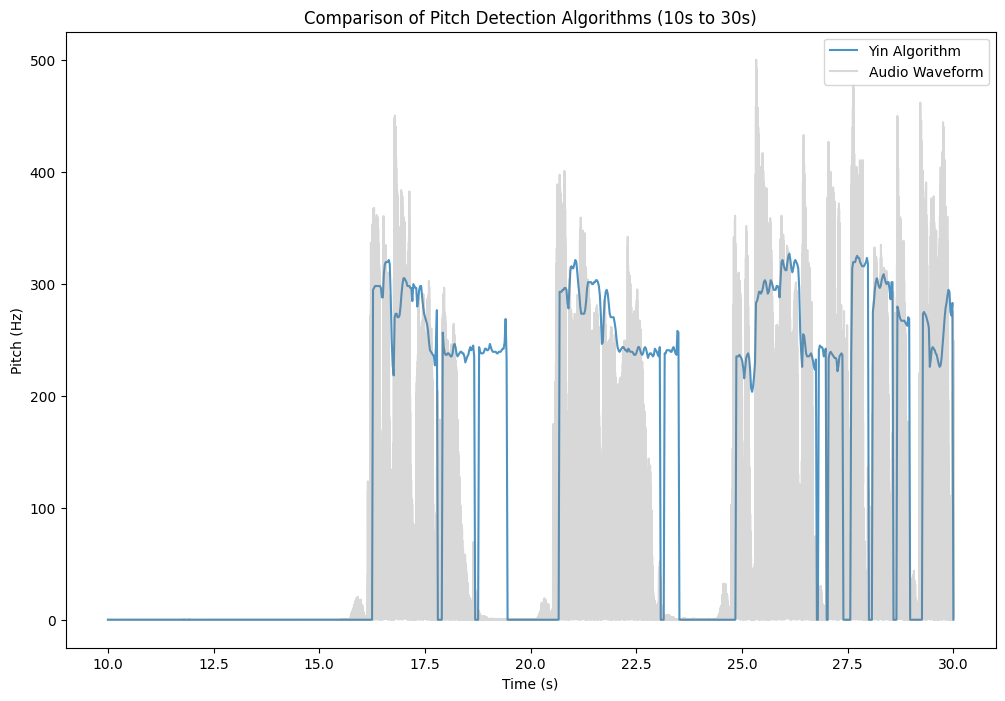

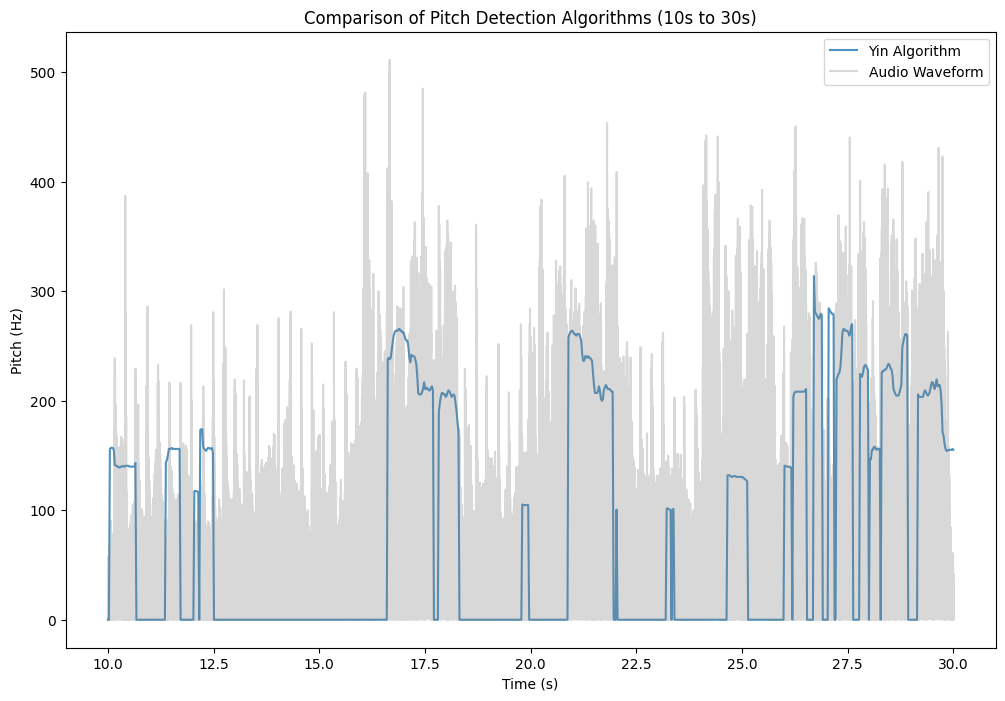

In [4]:
pitchVoice = compare_algorithms(voice, srV, 10, 30, True)

pitchGuitar = compare_algorithms(guitar, srG, 10, 30, True)

In [5]:
def obtener_notas(ref=440, Ndown=24, Nup=24):
    # Devuelve array con Ndown notas anteriores a ref (estimación de A4) y Nup notas posteriores
    # Valores por defecto para ir de A2 a A6 con referencia A4 puro

    notas = np.zeros(Ndown+Nup+1)
    A4 = Ndown
    notas[A4] = ref

    for i in range(Ndown):
        notas[A4-i-1] = notas[A4-i]*2**(-1/12)
    for i in range(Nup):
        notas[A4+i+1] = notas[A4+i]*2**(1/12)

    return notas

def distancia_notas(notas, ff):
    N = len(ff)
    distancias = np.zeros(N)
    distancias_indmin = np.zeros(N, dtype=int)

    for i in range(N):
        if ff[i]==0:
            distancias[i] = np.inf
            distancias_indmin[i] = -1
        else:
            distancias_indmin[i] = np.argmin(np.abs(12*np.log2(ff[i]/notas)))
            distancias[i] = 12*np.log2(ff[i]/notas[distancias_indmin[i]])

    return distancias, distancias_indmin

def desviacion_A4(distancias):

    desviacion_media = np.mean(distancias[np.isfinite(distancias)])
    desviacion_mediana = np.median(distancias[np.isfinite(distancias)])

    return desviacion_media, desviacion_mediana

def estandarizar_notas(notas, indices):

    N = len(indices)
    notas_estandar = np.zeros(N)

    for i in range(N):
        if indices[i] == -1:
            notas_estandar[i] = 0
        else:
            notas_estandar[i] = notas[indices[i]]

    return notas_estandar

In [6]:
notas = obtener_notas()
emily_dist, emily_dist_indmin = distancia_notas(notas, pitchVoice)
emily_ff_est = estandarizar_notas(notas, emily_dist_indmin)
police_dist, police_dist_indmin = distancia_notas(notas, pitchGuitar)
police_ff_est = estandarizar_notas(notas, police_dist_indmin)

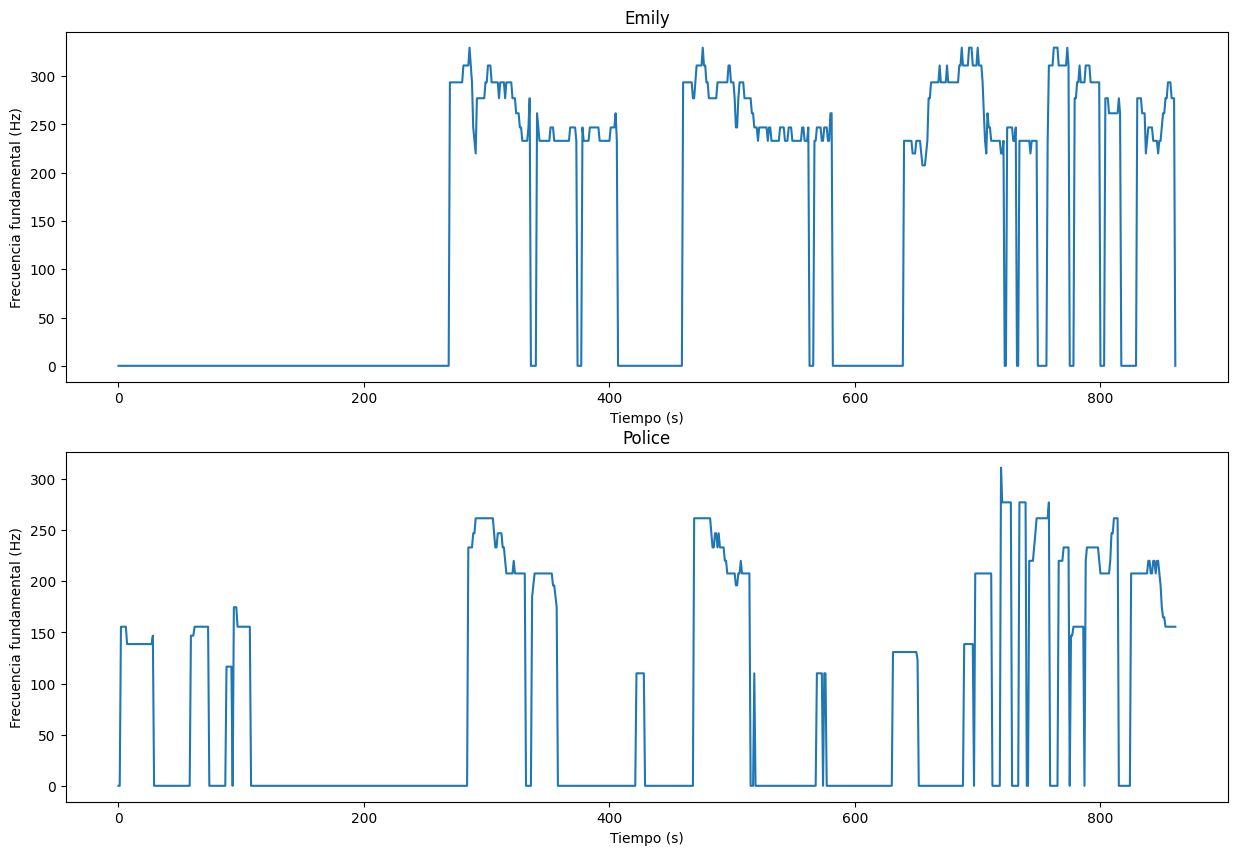

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
axs[0].plot(emily_ff_est)
axs[0].set_title('Emily')
axs[0].set_xlabel('Tiempo (s)')
axs[0].set_ylabel('Frecuencia fundamental (Hz)')
axs[1].plot(police_ff_est)
axs[1].set_title('Police')
axs[1].set_xlabel('Tiempo (s)')
axs[1].set_ylabel('Frecuencia fundamental (Hz)')
plt.show()

In [8]:
# Instalar las bibliotecas necesarias
!pip install fastdtw dtaidistance matplotlib


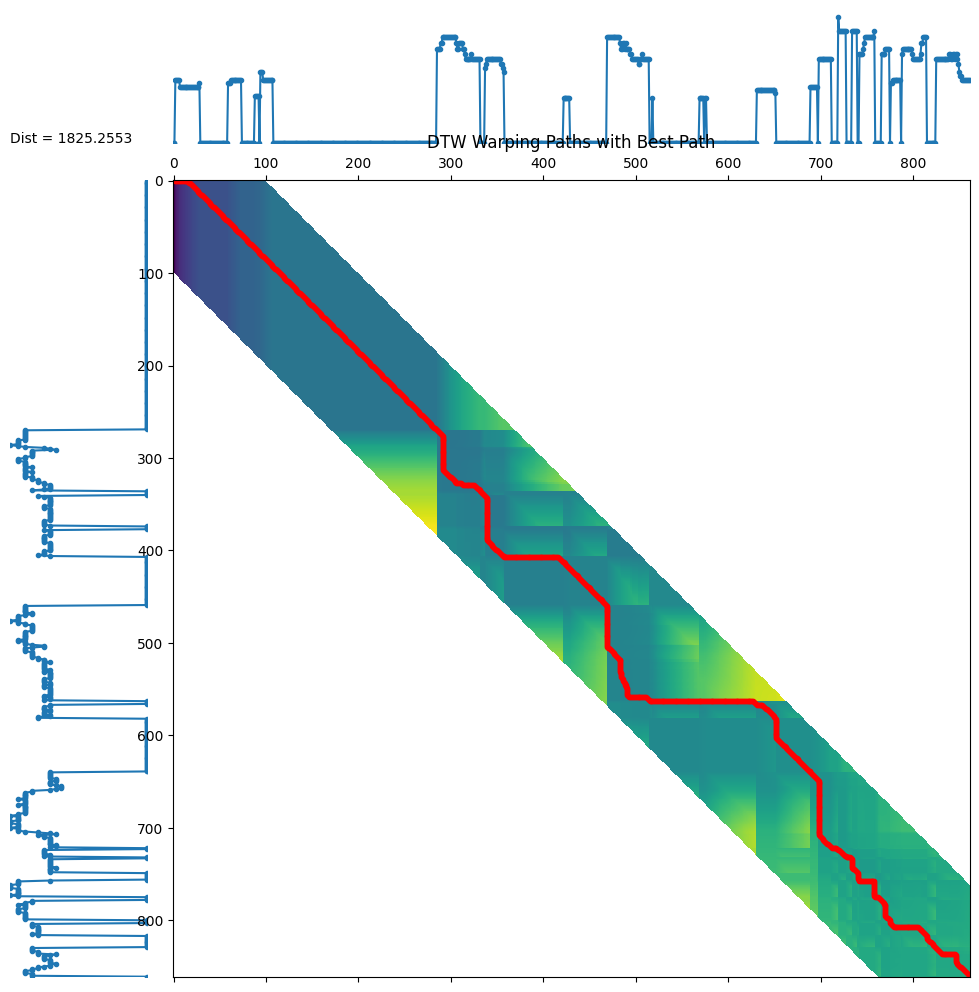

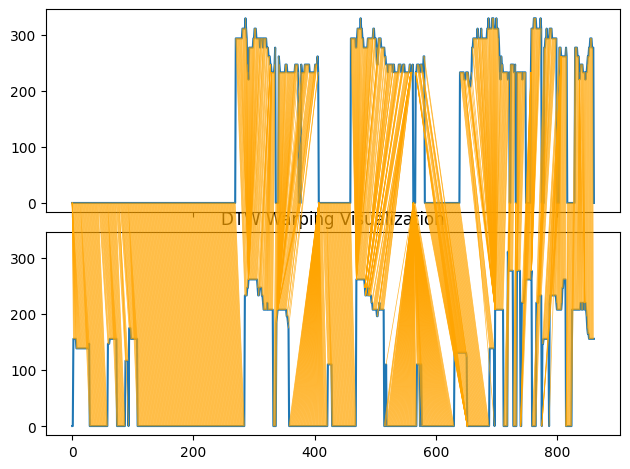

In [9]:

import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from dtaidistance import dtw, dtw_visualisation as dtwvis

# Calcular la matriz de caminos y encontrar el mejor camino con restricciones
window = 100  # Ventana de restricción
psi = 2      # Tolerancia en los extremos
d, paths = dtw.warping_paths(emily_ff_est, police_ff_est, window=window, psi=psi)
best_path = dtw.best_path(paths)

# Visualizar las warping paths y el mejor camino
dtwvis.plot_warpingpaths(emily_ff_est, police_ff_est, paths, best_path)
plt.title("DTW Warping Paths with Best Path")
plt.show()

# Visualizar las secuencias con el camino óptimo
dtwvis.plot_warping(emily_ff_est, police_ff_est, best_path)
plt.title("DTW Warping Visualization")
plt.show()

In [10]:
from scipy.interpolate import interp1d
from IPython.display import Audio
import numpy as np

def synchronize_tracks(emily_ff_est, police_ff_est, best_path):
    """
    Sincroniza dos pistas basadas en el mejor camino DTW y combina las señales.

    Parameters:
        emily_ff_est (np.ndarray): La primera pista.
        police_ff_est (np.ndarray): La segunda pista.
        best_path (list of tuples): El mejor camino DTW para la alineación.

    Returns:
        combined_track (np.ndarray): La pista combinada sincronizada.
    """
    # Crear listas para las señales alineadas
    aligned_emily = []
    aligned_police = []

    # Recorremos el mejor camino y alineamos las señales
    for i, j in best_path:
        aligned_emily.append(emily_ff_est[i])
        aligned_police.append(police_ff_est[j])

    # Convertir a arrays
    aligned_emily = np.array(aligned_emily)
    aligned_police = np.array(aligned_police)

    # Combinar las pistas (puedes sumar, promediar, etc.)
    combined_track = (aligned_emily + aligned_police) / 2  # Promedio simple

    return combined_track

# Sincronizar las pistas
combined_track = synchronize_tracks(voice, guitar, best_path)

# Reproducir la pista combinada
sample_rate = 22050  # Asegúrate de que sea consistente con las pistas originales
Audio(combined_track, rate=sample_rate)
